<a href="https://colab.research.google.com/github/Mohitranga/deep-learning/blob/main/Bet_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Mohitranga/deep-learning.git

Cloning into 'deep-learning'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



2.4.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 50.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt

In [ ]:
import os
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.sparse as sp

In [ ]:
dataset = Planetoid(root='/tmp/cora', name='Cora')
data=dataset[0]

Processing...
Done!


In [ ]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 2708
Number of edges: 10556
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

(2, 10556)


array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]])

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


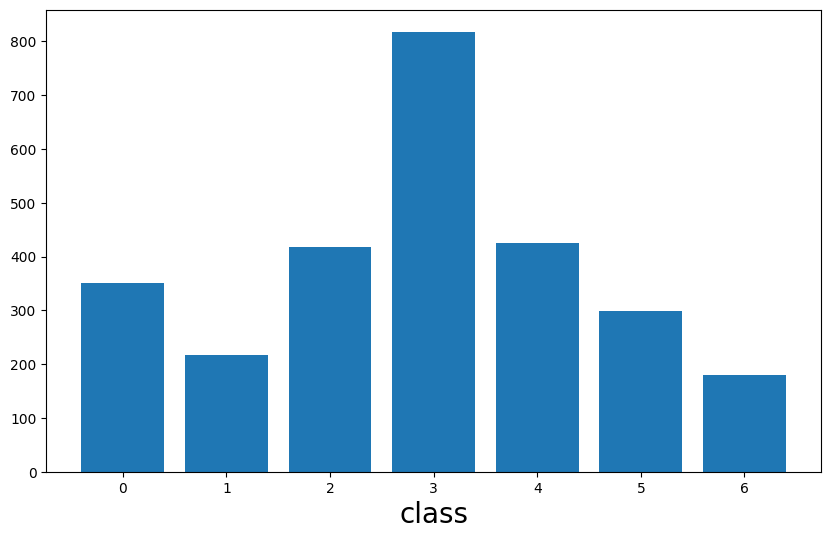

In [ ]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

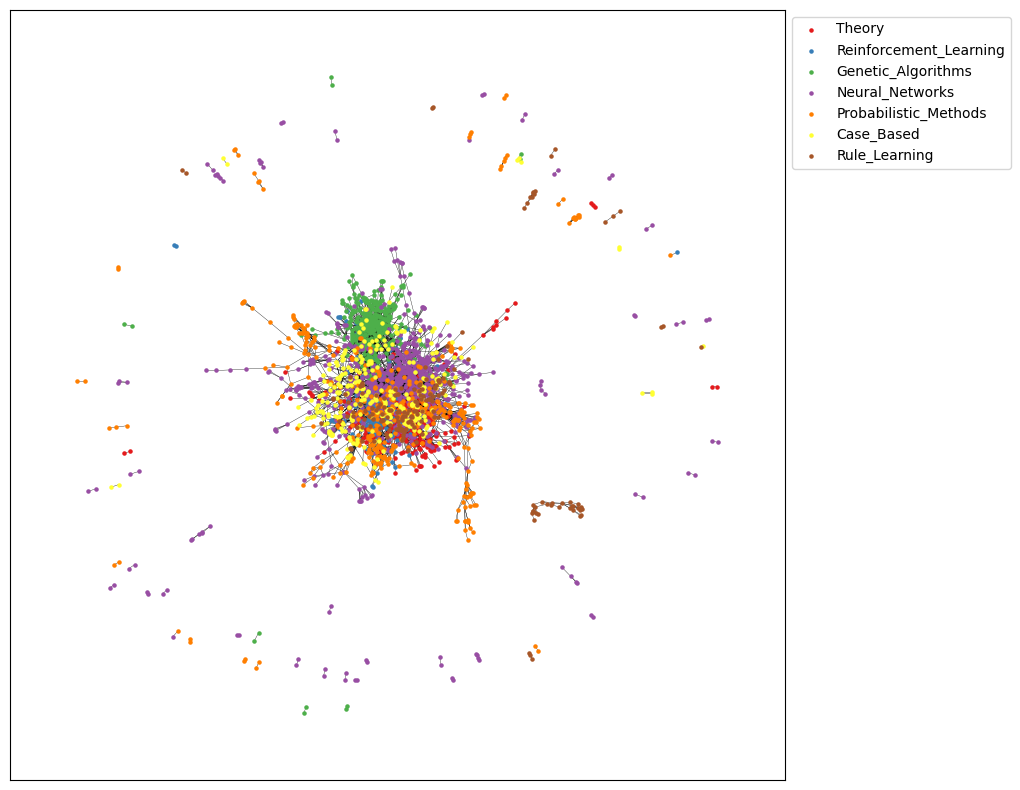

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx

G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [ ]:
G = to_networkx(data, to_undirected=True)
betweenness_centrality = nx.betweenness_centrality(G)

sorted_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)
top_percent = int(0.1 * len(sorted_nodes))
top_nodes = sorted_nodes[:top_percent]

high_centrality_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
high_centrality_mask[top_nodes] = True

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(hidden_channels=16).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[high_centrality_mask], data.y[high_centrality_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return acc

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
losses = []
accuracies = []

for epoch in range(1, 201):
    loss = train()
    acc = test()
    losses.append(loss)
    accuracies.append(acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.3545, Accuracy: 0.8180
Epoch: 002, Loss: 0.2729, Accuracy: 0.8170
Epoch: 003, Loss: 0.3301, Accuracy: 0.8190
Epoch: 004, Loss: 0.3320, Accuracy: 0.8140
Epoch: 005, Loss: 0.3191, Accuracy: 0.8130
Epoch: 006, Loss: 0.3482, Accuracy: 0.8180
Epoch: 007, Loss: 0.2810, Accuracy: 0.8230
Epoch: 008, Loss: 0.2599, Accuracy: 0.8220
Epoch: 009, Loss: 0.3375, Accuracy: 0.8180
Epoch: 010, Loss: 0.2907, Accuracy: 0.8160
Epoch: 011, Loss: 0.3383, Accuracy: 0.8160
Epoch: 012, Loss: 0.3187, Accuracy: 0.8180
Epoch: 013, Loss: 0.3010, Accuracy: 0.8190
Epoch: 014, Loss: 0.3160, Accuracy: 0.8170
Epoch: 015, Loss: 0.2852, Accuracy: 0.8160
Epoch: 016, Loss: 0.3578, Accuracy: 0.8180
Epoch: 017, Loss: 0.3680, Accuracy: 0.8180
Epoch: 018, Loss: 0.4245, Accuracy: 0.8180
Epoch: 019, Loss: 0.3613, Accuracy: 0.8210
Epoch: 020, Loss: 0.4123, Accuracy: 0.8180
Epoch: 021, Loss: 0.3195, Accuracy: 0.8150
Epoch: 022, Loss: 0.3328, Accuracy: 0.8170
Epoch: 023, Loss: 0.3071, Accuracy: 0.8160
Epoch: 024,

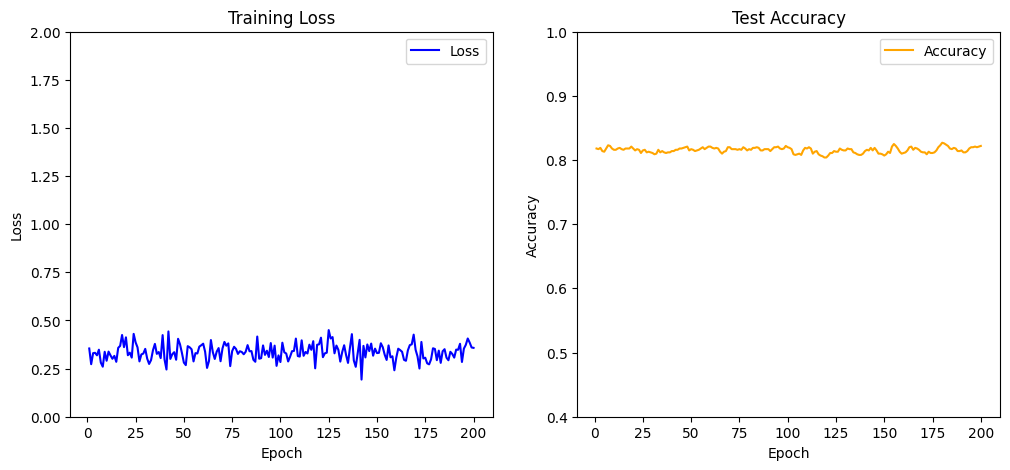

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Training Loss with y-axis limits from 0 to 2
plt.subplot(1, 2, 1)
plt.plot(range(1, 201), losses, label='Loss', color='blue')  # Use blue for consistency
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.ylim(0, 2)  # Set y-axis limit for loss to match the graph
plt.legend()

# Plot Test Accuracy with y-axis limits from 0.4 to 1.0
plt.subplot(1, 2, 2)
plt.plot(range(1, 201), accuracies, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.ylim(0.4, 1.0)  # Set y-axis limit for accuracy
plt.legend()

plt.show()
